# Disaster tweets classifier

I have chosen this Kaggle competition because I don't have much experience with NLP projects and I wanted to get started into this field. This project seems like a good opportunity to start applying text processing techniques and get fluency.

From Kaggle competition page:

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In [2]:
import numpy as np
import os
import re
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

Using TensorFlow backend.


## 1. Exploratory Data Analysis

### 1.1 Read train and test datasets

In [79]:
import pandas as pd

train = pd.read_csv('./input/tweets_data/train.csv')
test = pd.read_csv('./input/tweets_data/test.csv')

train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2 Get the total number of samples in both datasets

In [80]:
train_total_rows = train.shape[0]
test_total_rows = test.shape[0]

print(f"Total number of train samples = {train_total_rows} \n\
Total number of test samples = {test_total_rows}")

Total number of train samples = 7613 
Total number of test samples = 3263


### 1.3 Checking class distribution

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

values = train.target.value_counts()
print(f"Total number of disaster samples (1) = {values[1]} \n\
Total number of non disaster samples (0) = {values[0]}")

Total number of disaster samples (1) = 3271 
Total number of non disaster samples (0) = 4342


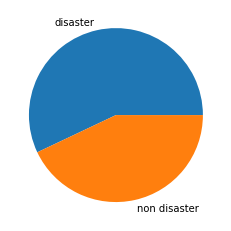

In [82]:
labels = ["disaster", "non disaster"]
plt.pie(values, labels=labels)
plt.show()

### 1.4 Get number of characters in tweets

In [83]:
calculate_len = lambda x: len(str(x))

disaster_tweet_len = list(map(calculate_len, train[train['target']==1]['text']))
no_disaster_tweet_len = list(map(calculate_len, train[train['target']==0]['text']))

Text(0.5, 0, 'Disaster tweets')

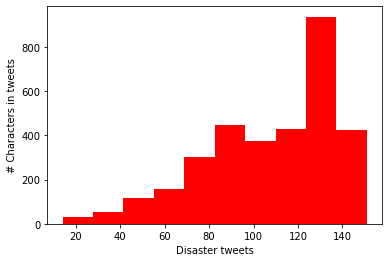

In [84]:
plt.hist(disaster_tweet_len, color='red')
plt.ylabel('# Characters in tweets')
plt.xlabel('Disaster tweets')

Text(0.5, 0, 'No Disaster tweets')

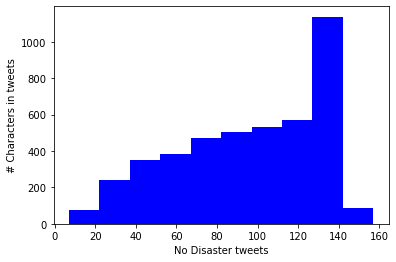

In [85]:
plt.hist(no_disaster_tweet_len, color='blue')
plt.ylabel('# Characters in tweets')
plt.xlabel('No Disaster tweets')

### 1.5 Get number of words in each tweet

In [86]:
calculate_words = lambda x: str(x).split()

disaster_tweet_len = list(map(lambda x: len(x), list(map(calculate_words, train[train['target']==1]['text']))))
no_disaster_tweet_len = list(map(lambda x: len(x), list(map(calculate_words, train[train['target']==0]['text']))))

Text(0.5, 0, 'Disaster tweets')

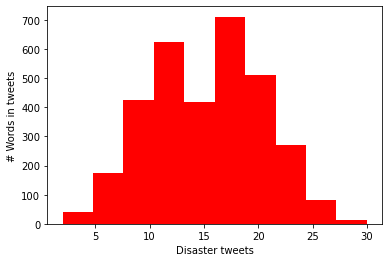

In [87]:
plt.hist(disaster_tweet_len, color='red')
plt.ylabel('# Words in tweets')
plt.xlabel('Disaster tweets')

Text(0.5, 0, 'No Disaster tweets')

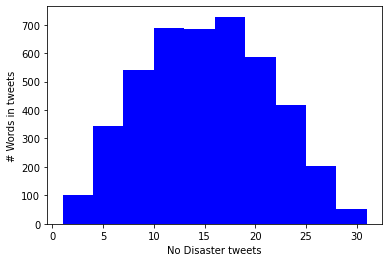

In [88]:
plt.hist(no_disaster_tweet_len, color='blue')
plt.ylabel('# Words in tweets')
plt.xlabel('No Disaster tweets')

### 1.8 Analize punctuations marks in non-disaster class (0)

In [89]:
import string
from collections import defaultdict

# Define corpus both both classes
punctuation_corpus_no_disaster = [i for x in str(train[train['target']==0]['text']).split() for i in x]
punctuation_corpus_disaster = [i for x in str(train[train['target']==0]['text']).split() for i in x]

def count_punctuation_marks(corpus):
    punctuation_counter = defaultdict(int)
    for word in corpus:
        if word in string.punctuation:
            punctuation_counter[word] = punctuation_counter[word]+1
    return punctuation_counter

<BarContainer object of 7 artists>

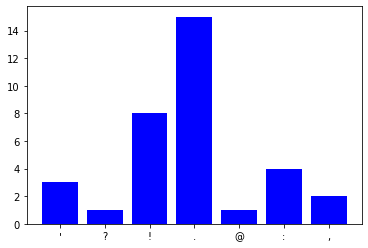

In [90]:
# Punctuation marks for no disaster tweets
pmark, counter = zip(*count_punctuation_marks(punctuation_corpus_no_disaster).items())

plt.bar(pmark, counter, color='blue')

### 1.9 Analize punctuations marks in disaster class (1)

<BarContainer object of 7 artists>

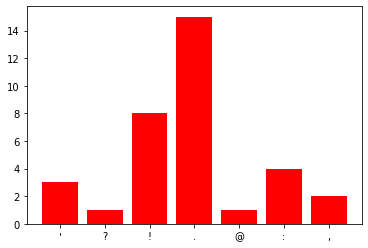

In [64]:
# Punctuation marks for disaster tweets
pmark_disaster, counter_disaster = zip(*count_punctuation_marks(punctuation_corpus_disaster).items())

plt.bar(pmark_disaster, counter_disaster, color='red')

### 1.10 Download stopwords

In [66]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.11 Get the most common words for no disaster tweets

In [112]:
corpus_no_disaster = [x for x in str(train[train['target']==0]['text']).split()]
corpus_disaster = [x for x in str(train[train['target']==0]['text']).split()]

<AxesSubplot:ylabel='words'>

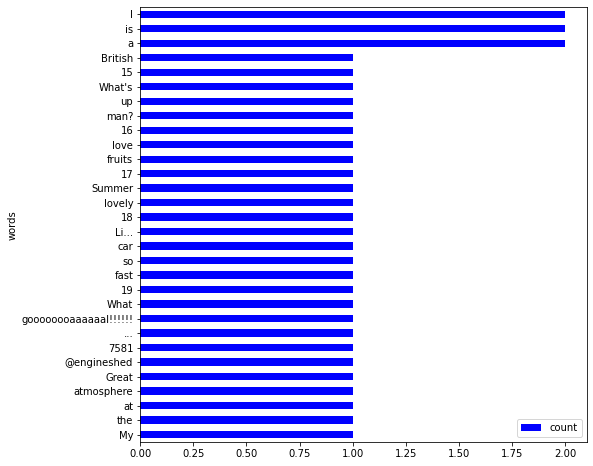

In [109]:
from collections import Counter

counter = Counter(corpus_no_disaster)
top_counting = counter.most_common()

most_common_words_no_disaster = pd.DataFrame(top_counting[:30],
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))
most_common_words_no_disaster.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="blue")

### 1.11 Get the most common words for disaster tweets

<AxesSubplot:ylabel='words'>

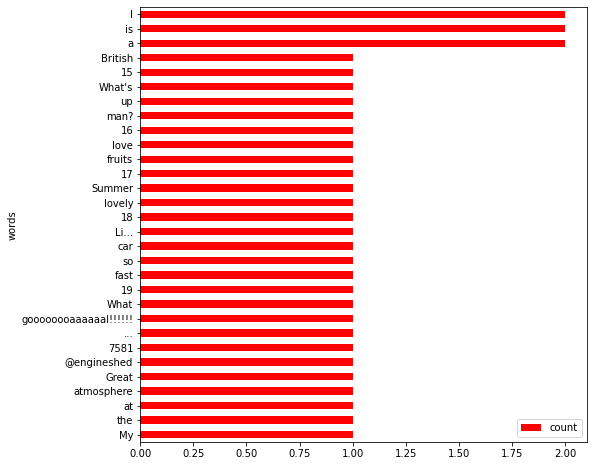

In [110]:
counter = Counter(corpus_disaster)
top_counting = counter.most_common()

most_common_words_disaster = pd.DataFrame(top_counting[:30],
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))
most_common_words_disaster.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="red")

### 1.12 Bigram analysis for no disaster tweets

<AxesSubplot:>

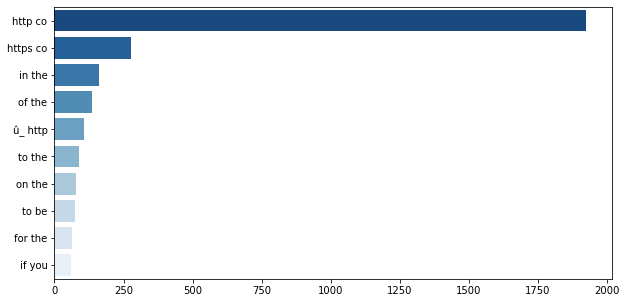

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

corpus_no_disaster_text = train[train['target']==0]['text']

vector = CountVectorizer(ngram_range=(2, 2))
ngrams = vector.fit_transform(corpus_no_disaster_text)

# Counting frecuency of ngrams
ngrams_frecuency = ngrams.sum(axis=0)

# Get the top ngrams
words_frequency = [(word, ngrams_frecuency[0, index]) for word, index in vector.vocabulary_.items()]
top_words = sorted(words_frequency, key = lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y = map(list,zip(*top_words))
sns.barplot(x=y,y=x, palette='Blues_r')

### 1.12 Bigram analysis for  disaster tweets

<AxesSubplot:>

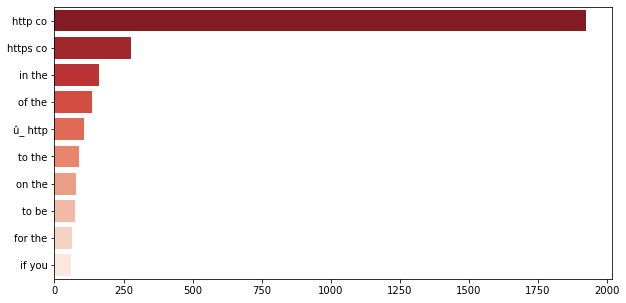

In [129]:
corpus_no_disaster_text = train[train['target']==1]['text']

vector_disaster = CountVectorizer(ngram_range=(2, 2))
ngrams_disaster = vector.fit_transform(corpus_no_disaster_text)

# Counting frecuency of ngrams
ngrams_frecuency_disaster = ngrams.sum(axis=0)

# Get the top ngrams
words_frequency_disaster = [(word, ngrams_frecuency_disaster[0, index]) for word, index in vector.vocabulary_.items()]
top_words_disaster = sorted(words_frequency_disaster, key = lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y = map(list,zip(*top_words))
sns.barplot(x=y,y=x, palette='Reds_r')

## 2. Data cleaning

In [131]:
def text_to_lower(text):
    """Make text lowercase"""
    return text.lower()

def remove_square_brackets(text):
    """Remove square brackets"""
    text = re.sub('\[.*?\]', '', text)
    return text

def remove_links(text):
    """Remove links"""
    text = re.sub('https?://\S+|www\.\S+', '', text)
    return text

def remove_punctuation_marks(text):
    """Remove punctuation marks"""
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    return text

def remove_words_numbers(text):
    """Remove words that are numbers"""
    text = re.sub('\w*\d\w*', '', text)
    return text

### 2.2 Applying the cleaning function to both test and training datasets

In [133]:
# Concat the two dataframes
dataframes = pd.concat([train,test])

dataframes['text'].apply(lambda x: text_to_lower(x)) \
    .apply(lambda x: remove_square_brackets(x)) \
    .apply(lambda x: remove_links(x)) \
    .apply(lambda x: remove_punctuation_marks(x)) \
    .apply(lambda x: remove_words_numbers(x))

dataframes['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

### 2.3 Removing emojis

In [135]:

def clean_emojis(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE).sub(r'', text)


dataframes['text'] = dataframes['text'].apply(lambda x: clean_emojis(x))

In [136]:
train_values = train.text.values
train_classes = train.target.values
test_values = test.text.values

## 3. Preprocessing

### 3.1 Tokenization

Firt, it is necessary to perform tokenization to split the text into sentences of words. With this tokenization step we get the text into a format that is easier to convert to raw numbers, which can actually be used for the model later.

In [19]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_values)
vocab_length = len(word_tokenizer.word_index) + 1

In [22]:
nltk.download('punkt')

longest_train = max(train_values, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(tokenizer.texts_to_sequences(train_values), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    tokenizer.texts_to_sequences(test_values), 
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 3.2 GloVe

To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!mkdir ./input/glove6b
!unzip -q glove.6B.zip -d ./input/glove6b

--2021-03-28 17:24:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-28 17:24:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-28 17:24:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
embeddings_dictionary = dict()
embedding_dim = 100
with open('./input/glove6b/glove.6B.100d.txt') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [25]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
!rm -rf ./input/glove6b
!rm glove.6B.zip

## 4. Model preparation and implementation

For solving this problem I decided to use LSTM (long short-term memory) model because it solves a vanishing gradient problem.

### 4.1 Splitting data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    train_classes, 
    test_size=0.25
)

### 4.2 Model implementation

In [28]:
def model_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = model_lstm()

In [29]:
!pip install pydot

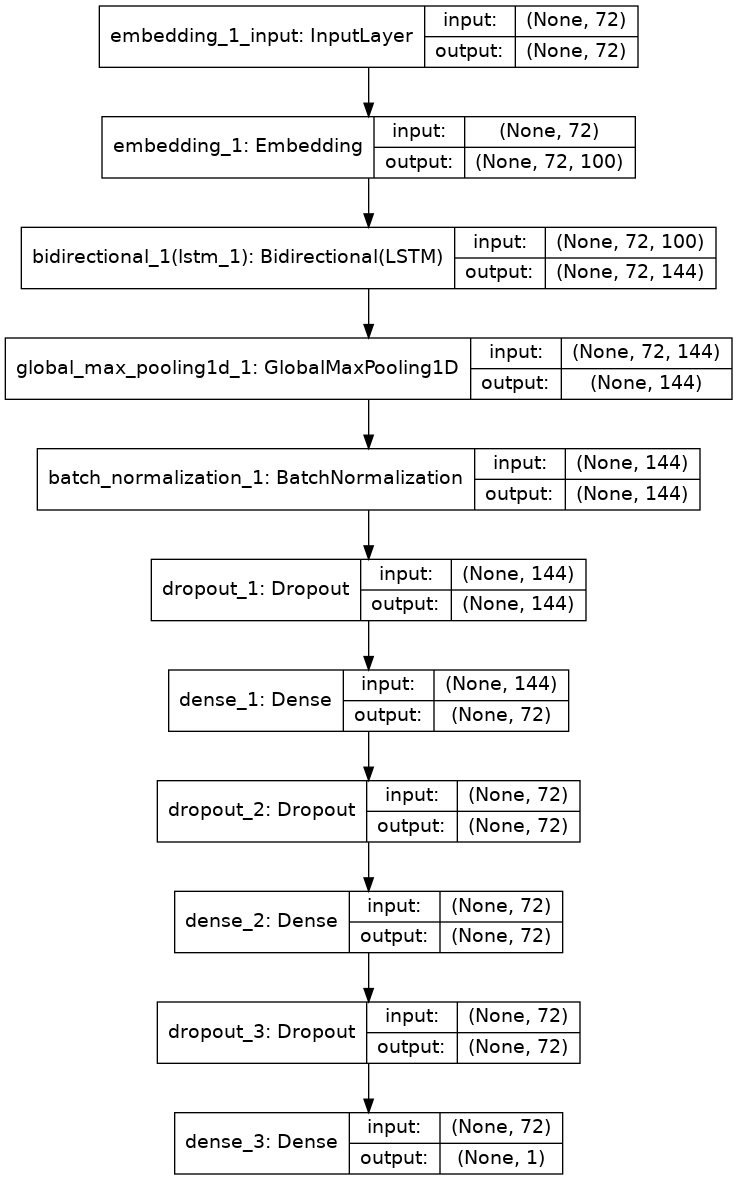

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 4.3 Model training

In [31]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/7
5709/5709 [==============================] - 42s 7ms/step - loss: 0.6410 - accuracy: 0.6842 - val_loss: 0.5682 - val_accuracy: 0.7931

Epoch 00001: val_loss improved from inf to 0.56819, saving model to model.h5
Epoch 2/7
5709/5709 [==============================] - 35s 6ms/step - loss: 0.5034 - accuracy: 0.7765 - val_loss: 0.4660 - val_accuracy: 0.8057

Epoch 00002: val_loss improved from 0.56819 to 0.46599, saving model to model.h5
Epoch 3/7
5709/5709 [==============================] - 35s 6ms/step - loss: 0.4497 - accuracy: 0.8063 - val_loss: 0.4335 - val_accuracy: 0.8057

Epoch 00003: val_loss improved from 0.46599 to 0.43352, saving model to model.h5
Epoch 4/7
5709/5709 [==============================] - 38s 7ms/step - loss: 0.4286 - accuracy: 0.8226 - val_loss: 0.4240 - val_accuracy: 0.8114

Epoch 00004: val_loss improved from 0.43352 to 0.42401, saving model to model.h5
Epoch 5/7
5709/5709 [==============================]

## 5 Model evaluation

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

1904/1904 [==============================] - 1s 774us/step
Loss: 0.4414563239121637
Accuracy: 0.8103991746902466


### 5.1 Model reporting

In [34]:
preds = model.predict_classes(X_test)
print("F1-score: ", f1_score(preds, y_test))
print("Precision: ", precision_score(preds, y_test))
print("Recall: ", recall_score(preds, y_test))
print("Acuracy: ", accuracy_score(preds, y_test))
print(classification_report(prediction_tag, y_test))

F1-score:  0.7508626639061422
Precision:  0.6766169154228856
Recall:  0.8434108527131783
Acuracy:  0.8103991596638656
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1259
           1       0.68      0.84      0.75       645

    accuracy                           0.81      1904
   macro avg       0.79      0.82      0.80      1904
weighted avg       0.83      0.81      0.81      1904



In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb = MultinomialNB()

nb.fit(X_train, y_train)
pred_class = nb.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(y_test, pred_class))
print("Precision", metrics.precision_score(y_test, pred_class))
print("Recall", metrics.recall_score(y_test, pred_class))
print("Recall", metrics.f1_score(y_test, pred_class))

Accuracy:  0.5845588235294118
Precision 0.5075669383003493
Recall 0.5422885572139303
Recall 0.5243535778713169
